<font size=12>High Yeid Tokens</font>

# prep

In [22]:
import mitosheet
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import random
import numpy as np
import requests
from datetime import datetime
import os, time, sys

import ipywidgets as widgets
from ipywidgets import HBox, Layout

sys.path.append('/home/lstm/Github/jp-codes-ubuntu/modules/')
sys.path.append('/mnt/c/users/jp/Documents/Github/jp-codes-ubuntu/modules/')
import dummyf

from python_helpers import coingecko_get_data_by_id, coingecko_get_df, produce_mkt_weighted_index

# get market data from Binance (price)

In [ ]:
# get Binance symbols (USDT pairs)
result = requests.get('https://api.binance.com/api/v3/ticker/price')
js = result.json()
symbols = [x['symbol'] for x in js]
symbols_usdt = [x[:-4] for x in symbols if 'USDT' in x]

w_syms_BNB = widgets.interactive(dummyf.dummyf, x=widgets.SelectMultiple(options=sorted(symbols_usdt), layout=Layout(width='400px', height='150px')))
HBox([widgets.Label('select symbol pairs'), w_syms_BNB])

In [ ]:
# define symbol, start, end, interval, endpoint
symbols = list(w_syms_BNB.kwargs['x'])
start_date = '2017-01-01'  # Binance quotes available from 2017
end_date = datetime.today().strftime('%Y-%m-%d') # through today
interval = '1d'
URL = 'https://api.binance.com/api/v3/klines' # historical OHLV endpoint

# define column names
COLUMNS = ['Open_time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close_time', 'quote_av', 'trades', 
                   'tb_base_av', 'tb_quote_av', 'ignore']

In [ ]:
# get data
data = []

start = int(time.mktime(datetime.strptime(start_date + ' 00:00', '%Y-%m-%d %H:%M').timetuple())) * 1000
end = int(time.mktime(datetime.strptime(end_date +' 23:59', '%Y-%m-%d %H:%M').timetuple())) * 1000
params = {
    'symbol': symbols ,
    'interval': interval,
    'limit': 1000,
    'startTime': start,
    'endTime': end
}

while start < end:
    print(datetime.fromtimestamp(start // 1000)) # //: floor division
    params['startTime'] = start
    result = requests.get(URL, params = params)
    js = result.json()
    if js: print('runinng period:', datetime.fromtimestamp(js[0][0] // 1000)) 
    else: break        
    data.extend(js)  
    start = js[-1][0] + 60000  # move on to next iteration (60k = 1000 mins)

if not data:  
    print('no data available for the period.') 
    # return -1

df = pd.DataFrame(data)
df.columns = COLUMNS

df['Open_time'] = df.apply(lambda x:datetime.fromtimestamp(x['Open_time'] // 1000), axis=1)
df = df.drop(columns = ['Close_time', 'ignore'])
df['Symbol'] = symbol
df.loc[:, 'Open':'tb_quote_av'] = df.loc[:, 'Open':'tb_quote_av'].astype(float)  # string to float
df['trades'] = df['trades'].astype(int)
mitosheet.sheet(df, view_df=True)

# get market data from Coingecko (market cap & price)
Using Coingecko community-built library:https://github.com/man-c/pycoingecko <br>
Coingecko official doc: https://www.coingecko.com/en/api/documentation

In [23]:
# prep & get coin list
from pycoingecko import CoinGeckoAPI  # Community project. See: https://github.com/man-c/pycoingecko
import ipywidgets as widgets
from ipywidgets import HBox, Layout
import sys
sys.path.append('/home/lstm/Github/jp-codes-ubuntu/modules/')
import dummyf

cg = CoinGeckoAPI()
df_gecko = pd.DataFrame(cg.get_coins_list())

In [24]:
# check for symbol
check4 = ['comp', 'ohm', 'snx', 'susd', 'trx', 'vai', 'ht', 'sun', 'jst', 'win', 'ylz', 'qdao', 'btc', 'sol', 'eth',]
# compound, olympus, synthetix, synthetix USD, tron, venus, huobi, just, winklink, bitcoin, solana, ethereum

num_days = 5000

names = df_gecko.loc[df_gecko['symbol'].str.contains('|'.join(check4), case=False), :].name.to_list()
w_name = widgets.interactive(dummyf.dummyf, x=widgets.SelectMultiple(options=sorted(names), layout=Layout(width='400px', height='150px')))

HBox([widgets.Label('MLflow experiment name'), w_name])

In [75]:
list_names = w_name.kwargs['x']
list_sym = df_gecko.loc[df_gecko['name'].isin(list_names), :].id.to_list()
list_sym = ['compound-governance-token', 'just', 'olympus', 'wink', 'bitcoin', 'ethereum']
#'huobi-token', 'yieldzard', venus, 'sun', 'q-dao-governance-token-v1-0'
# 'tron': not high yield
# 'solana': too many event-driven market moves

In [76]:
df_mktcap = pd.DataFrame()
df_price = pd.DataFrame()
for sym in list_sym:
    gecko_id = sym
    ticker = df_gecko.loc[df_gecko['id']==gecko_id, 'symbol'].iloc[0].upper()
    gecko_data = cg.get_coin_market_chart_by_id(gecko_id, vs_currency='USD', days=num_days)
    
    df_mc = pd.DataFrame(gecko_data['market_caps'])
    df_mc.columns = ['date', ticker]
    df_mc['date'] = df_mc['date'].div(1000).apply(datetime.fromtimestamp)
    df_mc.set_index('date', inplace=True)
    df_mc.index = pd.DatetimeIndex(df_mc.index.date)
    df_mc = df_mc.loc[~df_mc.index.duplicated(keep='last'), :]    
    df_mktcap = pd.concat([df_mktcap, df_mc], axis=1, join='outer')    

    df_pr = pd.DataFrame(gecko_data['prices'])
    df_pr.columns = ['date', ticker]
    df_pr['date'] = df_pr['date'].div(1000).apply(datetime.fromtimestamp)
    df_pr.set_index('date', inplace=True)
    df_pr.index = pd.DatetimeIndex(df_pr.index.date)
    df_pr = df_pr.loc[~df_pr.index.duplicated(keep='last'), :]    
    df_price = pd.concat([df_price, df_pr], axis=1, join='outer')
df_mktcap.sort_index(inplace=True)
df_mktcap.index.name = 'date'
df_price.sort_index(inplace=True)
df_price.index.name = 'date'

# plot market data over timeline

In [84]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# extend df_events index to match df_mktcap 
index_padding = df_mktcap.index[~df_mktcap.index.isin(df_price.index)]
df_padding = pd.DataFrame(index=index_padding)

# extend df_mktcap index to match df_events
df_mktcap = pd.concat([df_mktcap, df_padding]).sort_index().replace({0:np.nan}).dropna()

# do the same for df_price
df_price = pd.concat([df_price, df_padding]).sort_index().dropna()

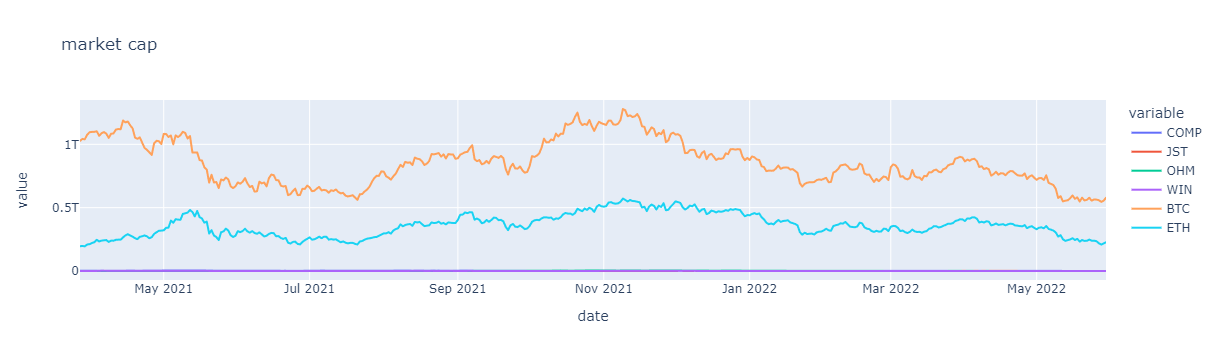

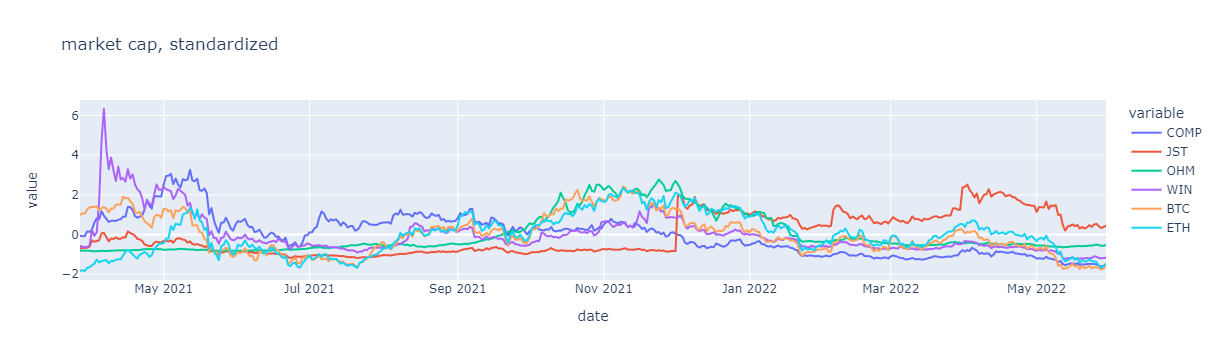

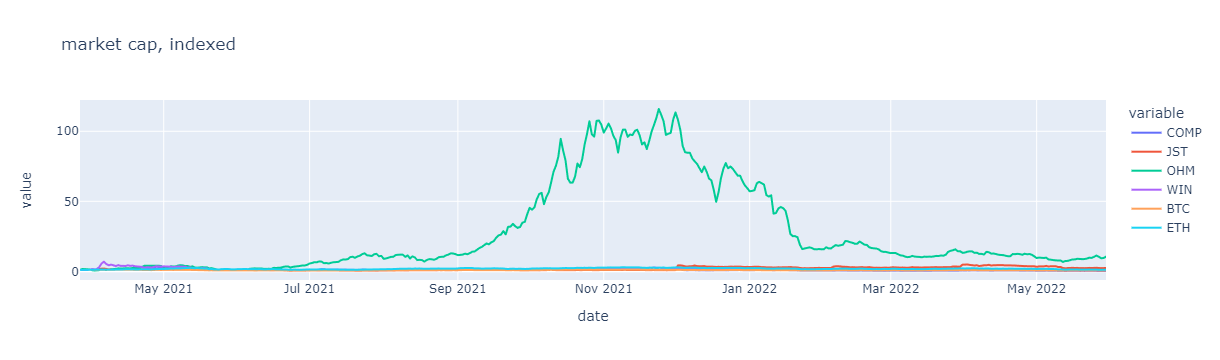

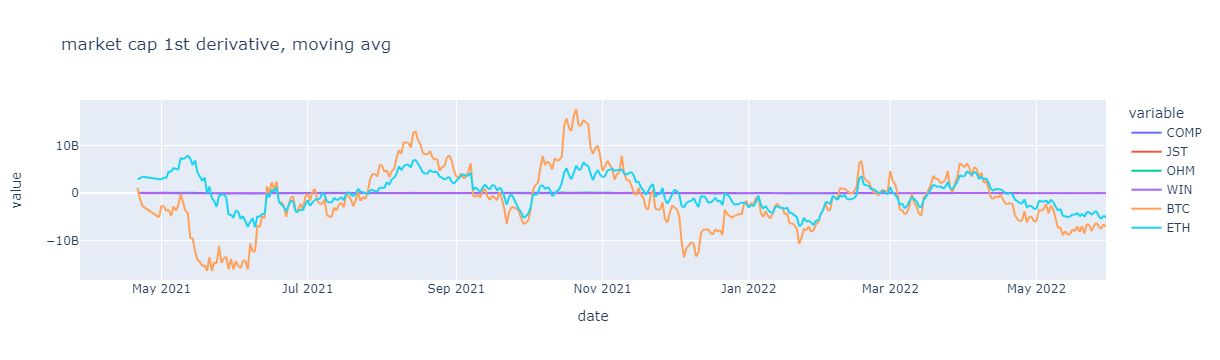

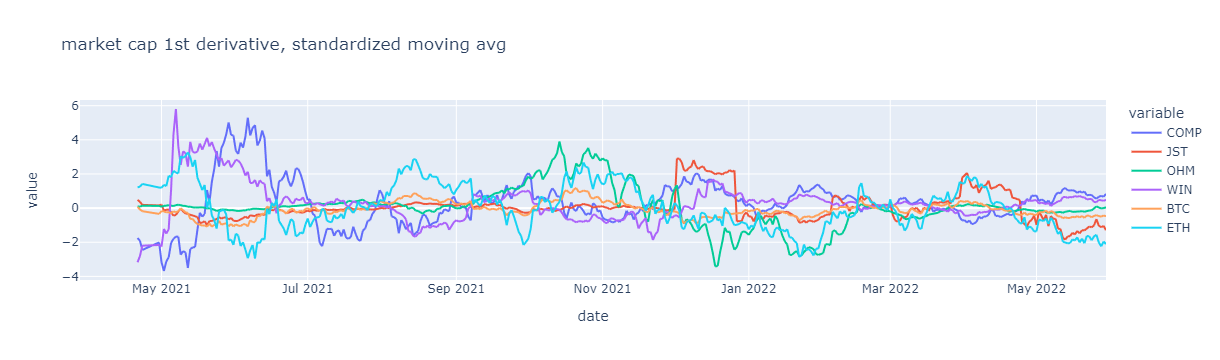

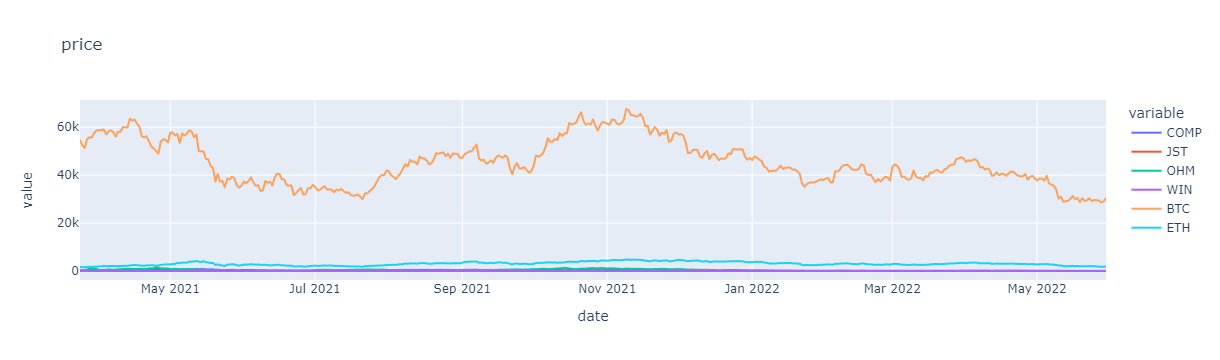

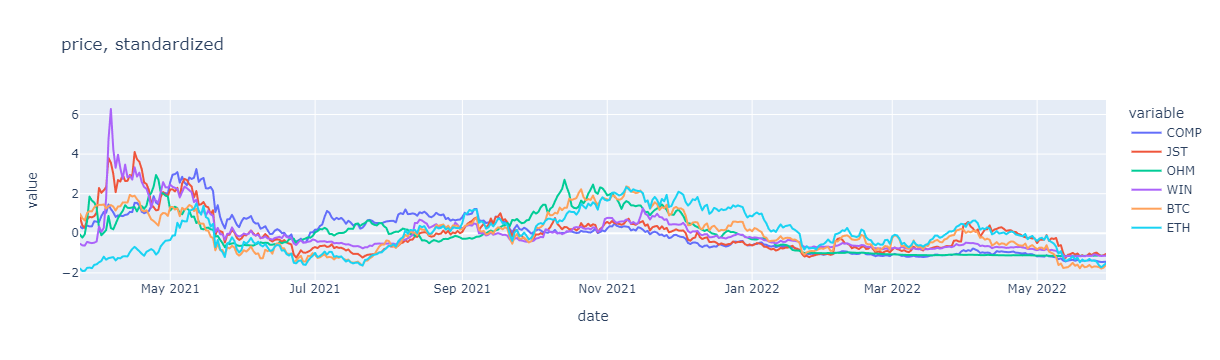

In [87]:
# plot
fig1 = px.line(df_mktcap, title='market cap')
fig1.show()

df_mktcap_std = (df_mktcap - df_mktcap.mean(axis=0))/df_mktcap.std(axis=0)
fig1_1 = px.line(df_mktcap_std, title='market cap, standardized')
fig1_1.show()

df_mktcap_idx = df_mktcap.div(df_mktcap.iloc[0,:], axis=1)
fig1_2 = px.line(df_mktcap_idx, title='market cap, indexed')
fig1_2.show()

# df_mkt_diff = df_mktcap.diff().div(df_mktcap.index.to_series().diff().dt.days, axis=0)
# df_mkt_diff_std = (df_mkt_diff - df_mkt_diff.mean())/df_mkt_diff.std()
# window_size = 25
# df_mkt_diff_std_roll = df_mkt_diff_std.rolling(window_size).mean()
# fig1_2 = px.line(df_mkt_diff_std_roll, title='market cap 1st derivative, standardized')
# fig1_2.show()

df_mkt_diff = df_mktcap.diff().div(df_mktcap.index.to_series().diff().dt.days, axis=0).replace({0:np.nan}).dropna()
window_size = 25
df_mkt_diff_roll = df_mkt_diff.rolling(window_size).mean()
fig1_2 = px.line(df_mkt_diff_roll, title='market cap 1st derivative, moving avg')
fig1_2.show()

df_mkt_diff_idx = df_mkt_diff.div(df_mkt_diff.iloc[0,:], axis=1)
window_size = 25
df_mkt_diff_idx_roll = df_mkt_diff_idx.rolling(window_size).mean()
fig1_3 = px.line(df_mkt_diff_idx_roll, title='market cap 1st derivative, standardized moving avg')
fig1_3.show()

fig3 = px.line(df_price, title='price')
fig3.show()

fig4 = px.line(df_price.apply(np.log10), title='price (log 10)')
fig4_1 = px.line((df_price - df_price.mean(axis=0))/df_price.std(axis=0), title='price, standardized')
fig4_1.show()

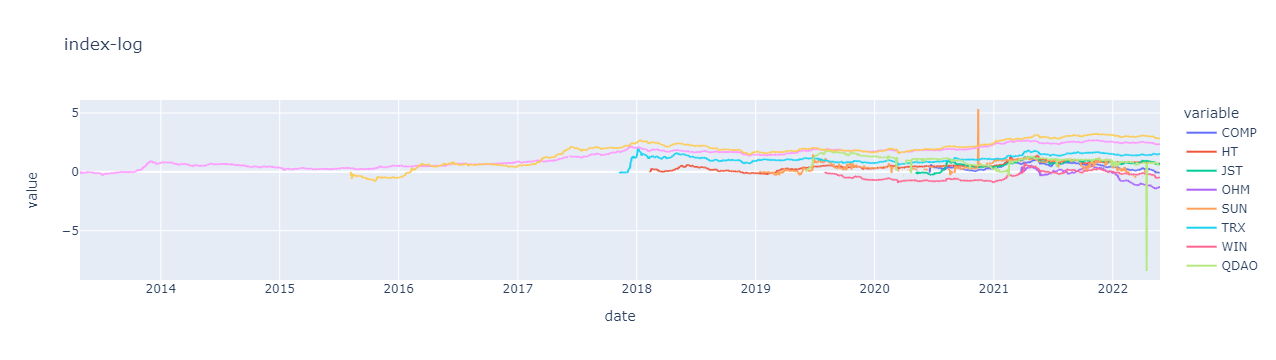

In [104]:
# index-ized, and then log
px.line(df_price.drop(columns=['SOL']).apply(lambda x: x.div(x.loc[~x.isnull()].iloc[0]), axis=0).apply(np.log10), title='index-log')